In [54]:
import torch.nn as nn
import torch

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
from data.dataloader import data_generator
from training.optimizer import get_optimizer
from models.losses import loss_function
from models.utils import eigen_decomp

In [57]:
from models.gru_denoiser import BiGRUSpectralDenoiser

à evoquer calcul dans GRU :
$$\hat{\Sigma} = \hat{Q} \hat{\Lambda} \hat{Q}^T$$

$$\tilde{\Sigma}_{NN} = \hat{Q} \tilde{\Lambda}_{NN} \hat{Q}^T$$

## NN

In [67]:
model = BiGRUSpectralDenoiser(hidden_size=64) # hidden_size to be tunned

### Training loop

On pourra rajouter dans la loss un terme pour comparer les valeurs propres/les matrices totals par exemples des matrices.

On pourrait calculer la loss par epochs d'une tailles plus petites ou même aléatoire

In [71]:
losses = []

In [72]:
N_min=80
N_max=300
T_min=80
T_max=200

In [73]:
optimizer = get_optimizer(model)

In [ ]:
# batch are full for now
batch_size = 64 # to be tunned 256 would be better but slow...
epochs = 150 # approximately (tunned)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    lam_emp, Q_emp, Sigma_true, T = next(data_generator(batch_size, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max))
    lam_pred = model(lam_emp)  # forward pass through the NN (GRU+fc)

    # compute losses
    loss = loss_function(lam_pred, Q_emp, Sigma_true, T)

    # backprop
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # very noisy optimization we could lower lr as loss deacreases
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} — loss: {loss.item():.6f}")


174 120
294 187
175 167
141 155
229 117
178 149
155 84
83 150
214 160
144 94
Epoch 10/50 — loss: 0.099553
232 189
126 178
119 182
91 158
294 128
246 151
141 88
236 160
247 190
89 99
Epoch 20/50 — loss: 0.154135
282 139
101 115
244 144
203 157
98 143
214 140
221 172
114 91
201 190
121 141
Epoch 30/50 — loss: 0.114936
85 119
154 118
131 175
104 131
294 97
281 169
81 138
152 140
294 103
177 91
Epoch 40/50 — loss: 0.065483
152 137
186 155
212 114
161 169
189 128
129 149
214 152
272 116
258 176
178 155
Epoch 50/50 — loss: 0.115180


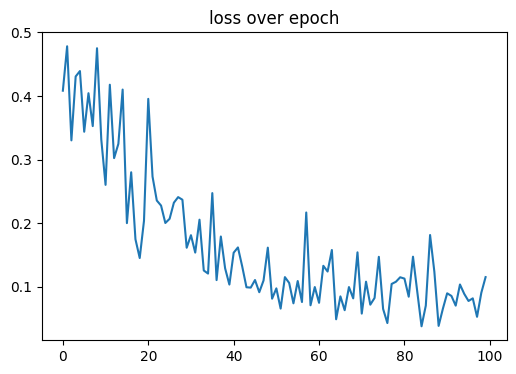

In [77]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

might go up and down because it really depends on the N and T randomly picked.

we have to stop after the slow down of deacrese. otherwise we might face overfitting

### out of sample comparaison 1

In [78]:
batch_size_oos_1 = 25
N_list_test_1 = [20, 40, 60, 80, 100, 120, 140, 160, 180,200,220]
T_list_test_1 = [20, 40,60, 80, 100, 120, 150, 180, 200, 220, 240, 260, 280, 300]

In [79]:
losses_value = []

In [80]:
for n in N_list_test_1:
    for t in T_list_test_1:
        lam_emp_oos_i, Q_emp_oos_i, Sigma_true_oos_i, T_t = next(data_generator(batch_size_oos_1, N_min=n, N_max=n, T_min=t, T_max=t))
        lam_pred_test_i = model(lam_emp_oos_i)
        losses_value.append(loss_function(lam_pred_test_i, Q_emp_oos_i, Sigma_true_oos_i, T_t).item())

20 20
20 40
20 60
20 80
20 100
20 120
20 150
20 180
20 200
20 220
20 240
20 260
20 280
20 300
40 20
40 40
40 60
40 80
40 100
40 120
40 150
40 180
40 200
40 220
40 240
40 260
40 280
40 300
60 20
60 40
60 60
60 80
60 100
60 120
60 150
60 180
60 200
60 220
60 240
60 260
60 280
60 300
80 20
80 40
80 60
80 80
80 100
80 120
80 150
80 180
80 200
80 220
80 240
80 260
80 280
80 300
100 20
100 40
100 60
100 80
100 100
100 120
100 150
100 180
100 200
100 220
100 240
100 260
100 280
100 300
120 20
120 40
120 60
120 80
120 100
120 120
120 150
120 180
120 200
120 220
120 240
120 260
120 280
120 300
140 20
140 40
140 60
140 80
140 100
140 120
140 150
140 180
140 200
140 220
140 240
140 260
140 280
140 300
160 20
160 40
160 60
160 80
160 100
160 120
160 150
160 180
160 200
160 220
160 240
160 260
160 280
160 300
180 20
180 40
180 60
180 80
180 100
180 120
180 150
180 180
180 200
180 220
180 240
180 260
180 280
180 300
200 20
200 40
200 60
200 80
200 100
200 120
200 150
200 180
200 200
200 220
200 240


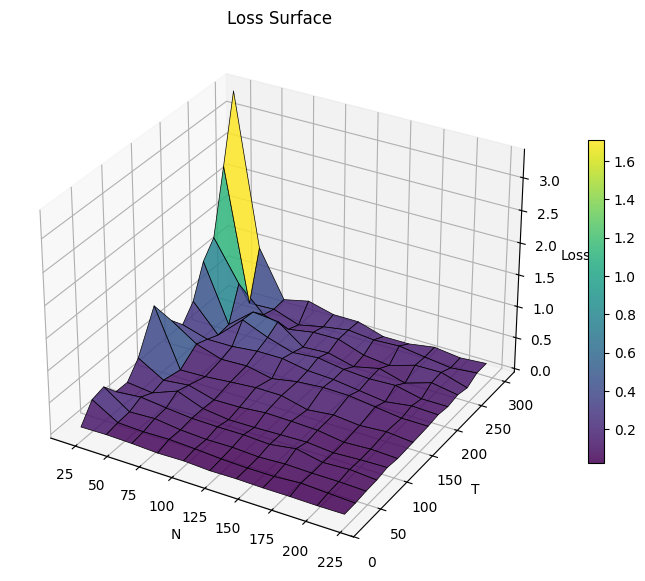

In [81]:
# meshing
loss_grid = np.array(losses_value).reshape(len(np.array(N_list_test_1)), len(np.array(T_list_test_1)))
N_mesh, T_mesh = np.meshgrid(np.array(N_list_test_1), np.array(T_list_test_1), indexing='ij')

# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

fig.colorbar(surf, shrink=0.6)
plt.savefig('images/loss_surface.png')
plt.show()

### out of sample comparaison 2

In [95]:
batch_size_oos = 1024

In [ ]:
lam_emp_oos, Q_emp_oos, Sigma_true_oos, T = next(data_generator(batch_size_oos, N_min=200, N_max=200, T_min=100, T_max=100))


200 100


In [ ]:
lam_pred_test = model(lam_emp_oos)

Comparaison eigenvalues $\lambda$

In [ ]:
# mse
mse = nn.MSELoss()

In [ ]:
lam_true_oos = torch.tensor(np.array([eigen_decomp(Sigma.numpy())[0] for Sigma in Sigma_true_oos]), dtype=torch.float32)


mse_pred_test_lam  = mse(lam_pred_test, lam_true_oos)
mse_noisy_test_lam = mse(lam_true_oos, lam_emp_oos.squeeze(-1))

print(f"MSE cleaned: {mse_pred_test_lam:.6f}")
print(f"MSE noisy  : {mse_noisy_test_lam:.6f}")


MSE cleaned: 0.043087
MSE noisy  : 62959906816.000000


Comparaison Trace

In [ ]:
trace_true_test = lam_true_oos.sum(dim=1).mean()
trace_pred_test = lam_pred_test.sum(dim=1).mean()
trace_noisy_test = lam_emp_oos.sum(dim=1).mean()

mse_tr_test_pred = mse(trace_true_test,trace_pred_test)
mse_tr_test_noisy = mse(trace_true_test,trace_noisy_test)

print(f"Real Trace : {trace_true_test:.4f}, predicted : {trace_pred_test:.4f}, noisy : {trace_noisy_test:.4f}")

print(f"MSE tr noisy  : {mse_tr_test_noisy:.6f}")
print(f"MSE tr cleaned: {mse_tr_test_pred:.6f}")

Real Trace : 53.4174, predicted : 37.2700, noisy : 238249.9375
MSE tr noisy  : 56737579008.000000
MSE tr cleaned: 260.738281


*10^6 fois mieux

Comparaison matrix $\Sigma$

In [ ]:
def reconstruct_cov(Q, lam):
    Lambda = torch.diag_embed(lam.squeeze(-1))
    Sigma = Q @ Lambda @ Q.transpose(1, 2)
    return Sigma

In [ ]:
Sigma_true_test = Sigma_true_oos
Sigma_noisy_test = reconstruct_cov(Q_emp_oos, lam_emp_oos)
Sigma_pred_test   = reconstruct_cov(Q_emp_oos, lam_pred_test)

fro_noisy_test_mat = mse(Sigma_noisy_test, Sigma_true_test)
fro_pred_test_mat   = mse(Sigma_pred_test, Sigma_true_test)

print(f"mse error (noisy):  {fro_noisy_test_mat:.6f}")
print(f"mse error (GRU)  :  {fro_pred_test_mat:.6f}")

mse error (noisy):  314799520.000000
mse error (GRU)  :  0.000528


supérieur à *10^6 fois mieux

Graphique : 

In [ ]:
pairs = ['Matrix', 'Trace', 'EigenValues']
mse_noisy   = [fro_noisy_test_mat.item(), mse_tr_test_noisy.item(), mse_noisy_test_lam.item()]
mse_cleaned = [fro_pred_test_mat.item(), mse_tr_test_pred.item(), mse_pred_test_lam.item()]

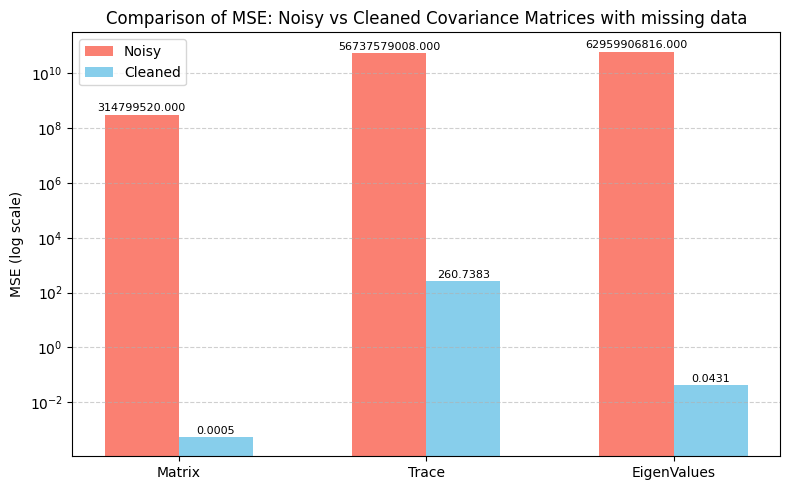

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(pairs))
width = 0.3

plt.figure(figsize=(8,5))
plt.bar(x - width/2, mse_noisy, width, label='Noisy', color='salmon')
plt.bar(x + width/2, mse_cleaned, width, label='Cleaned', color='skyblue')

plt.yscale('log')
plt.ylabel('MSE (log scale)')
plt.xticks(x, pairs)
plt.legend()
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)

for i, (n, c) in enumerate(zip(mse_noisy, mse_cleaned)):
    plt.text(x[i] - width/2, n*1.1, f"{n:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + width/2, c*1.1, f"{c:.4f}", ha='center', va='bottom', fontsize=8)

plt.title('Comparison of MSE: Noisy vs Cleaned Covariance Matrices with missing data')
plt.tight_layout()
plt.savefig('images/results_NN_oos')
plt.show()


### Add comparaison

#### Comparaison with no missing value

#### Comparaison with RIE estimator on no missing value

### Add hyperparameter selection

### Loss that minimizes the Portfolio Risk

To be added
- we could add : eigenvalues monotonically decreasing
- hyperparameter tuning
- k split cross validation
- try stochastic gradient descent

To be written in the report
- write abt RIE and that we do smt simular
- write abt GRU and how it helps us here
- a problem is that eigenVector are noisy